In [1]:
import pandas as pd

In [2]:
import numpy as np
import random

import matplotlib
import sklearn
from matplotlib import pyplot as plt

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [4]:
import mlflow
import mlflow.sklearn
import joblib

In [ ]:
experiment = "Fake Bills Classifier"
seed = 0

In [5]:
mlflow.set_experiment(experiment)

<Experiment: artifact_location='file:///home/cunning/studying/ISSII/lab2/mlruns/554530497060043608', creation_time=1732043009625, experiment_id='554530497060043608', last_update_time=1732043009625, lifecycle_stage='active', name='Fake Bills Classifier', tags={}>

In [6]:
dataset = pd.read_csv('dataset.csv', sep=';')

In [7]:
dataset.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [9]:
y = dataset.is_genuine.values
x = dataset.drop('is_genuine', axis=1)

In [10]:
for i in range(2000):
  raw = random.randint(0, x.shape[0])-1
  col = random.randint(0, x.shape[1])-1
  x.iloc[raw, col] = np.nan

In [11]:
for i in range(10):
  raw = random.randint(0, x.shape[0])-1
  col = random.randint(0, x.shape[1])-1
  x.iloc[raw, col] = x.iloc[raw, col] + random.randint(1000, 100000)


In [12]:
def plot_scores(optimizer, plot_path):
    plt.semilogx( optimizer.cv_results_['param_C'], optimizer.cv_results_['mean_test_score'])
    plt.fill_between(optimizer.cv_results_['param_C'], optimizer.cv_results_['mean_test_score']-optimizer.cv_results_['std_test_score'],
                                  optimizer.cv_results_['mean_test_score']+optimizer.cv_results_['std_test_score'], alpha=0.3)
    plt.savefig(plot_path)
    plt.close()  # Close the plot to free resources

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=seed)

In [14]:
mlflow.start_run(run_name="Init Model Training")
mlflow_run_id = mlflow.active_run().info.run_id

In [15]:
x_train_zeros = x_train[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].fillna(0)

In [16]:
x_test_zeros = x_test[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].fillna(0)

In [17]:
logistic_regression = LogisticRegression(random_state=seed)
logistic_regression.fit(x_train_zeros,y_train)
coef_norm = np.linalg.norm(logistic_regression.coef_)
mlflow.log_metric("coef_norm", coef_norm)

/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
param_grid = {'C' : [0.01, 0.5, 1, 5, 10, 100]}

In [19]:
clf_zeros = GridSearchCV(logistic_regression, param_grid, cv = 3, return_train_score=True)
clf_zeros.fit(x_train_zeros, y_train)
best = clf_zeros.best_estimator_
best_model_path = str(mlflow_run_id)+ "_best_estimator.pkl"
joblib.dump(best, best_model_path)
mlflow.log_artifact(best_model_path)
mlflow.log_param("best_C_hyperparam", best.C)

/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

5

In [20]:
plot_path = str(mlflow_run_id)+"_grid_search_score.png"
plot_scores(clf_zeros, plot_path)
mlflow.log_artifact(plot_path)

In [21]:
best.fit(x_train_zeros, y_train)
train_acc = best.score(x_train_zeros, y_train)
test_acc = best.score(x_test_zeros, y_test)
print("train  accuracy: {} ".format(train_acc))
print("test accuracy: {} ".format(test_acc))
mlflow.log_metrics({"train_accuracy": train_acc, "test_accuracy": test_acc})

train  accuracy: 0.7438095238095238 
test accuracy: 0.7177777777777777 
test accuracy: 0.7066666666666667 
train accuracy: 0.7304761904761905 


/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [22]:
mlflow.end_run()

## 1 гипотеза


In [23]:
mlflow.start_run(run_name="1st hypothesis")
mlflow_run_id = mlflow.active_run().info.run_id

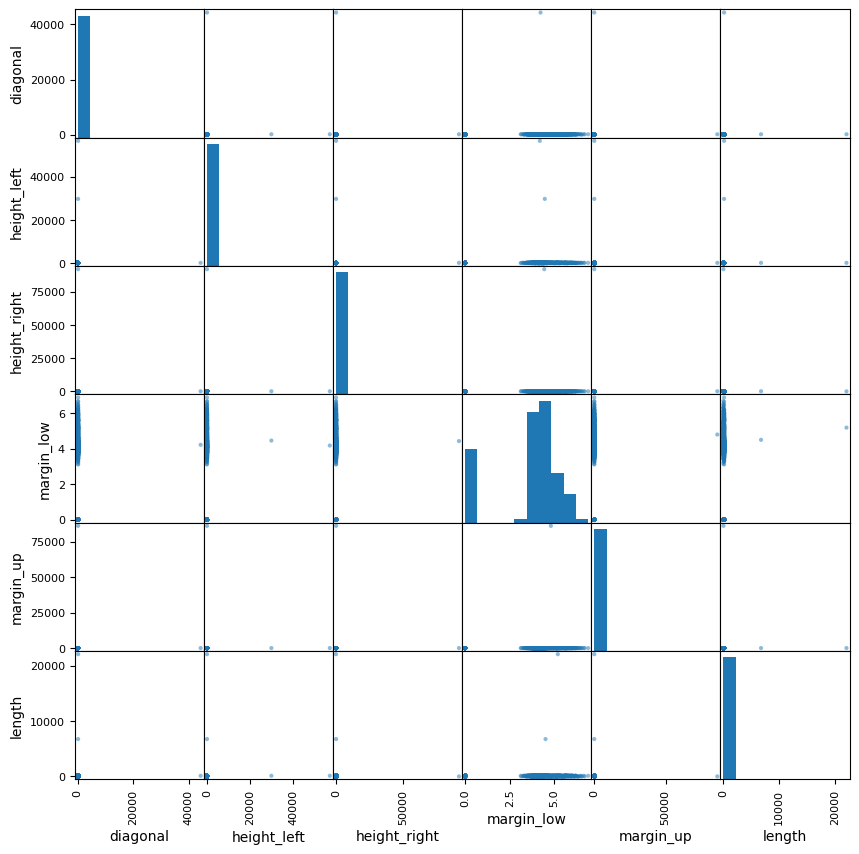

In [24]:
from pandas.plotting import scatter_matrix

data_numeric = pd.DataFrame(x_train_zeros, columns=x_train_zeros.columns)
list_cols = x_train_zeros.columns
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
fig_path = str(mlflow_run_id) + "_scatter_matrix.png"
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)
# plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(x_train_zeros)
X_test_real_scaled = scaler.transform(x_test_zeros)

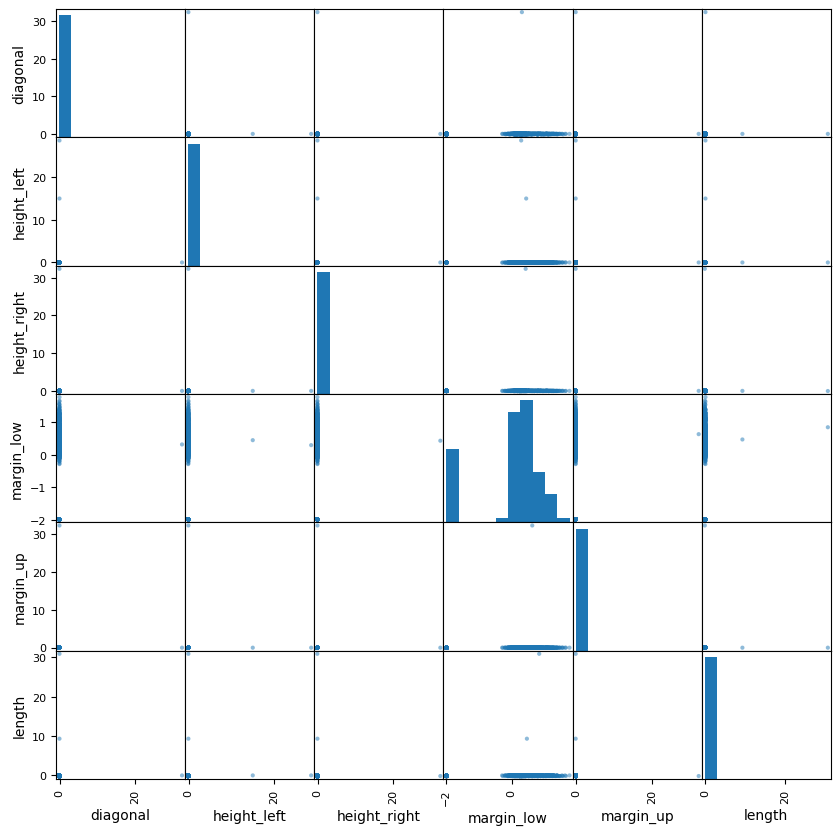

In [26]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=x_train.columns)
list_cols = x_train_zeros.columns
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
fig_path = str(mlflow_run_id) + "_scaled_scatter_matrix.png"
plt.savefig(fig_path)
mlflow.log_artifact(fig_path)
# plt.show()

In [27]:
estimator = LogisticRegression()
clf_scaled = GridSearchCV(estimator, param_grid, cv = 3)
clf_scaled.fit(X_train_real_scaled, y_train)
best = clf_scaled.best_estimator_
best_model_path = str(mlflow_run_id)+ "_best_estimator.pkl"
joblib.dump(best, best_model_path)
mlflow.log_artifact(best_model_path)
mlflow.log_param("best_C_hyperparam", best.C)
best

LogisticRegression(C=100)

In [28]:
plot_path = str(mlflow_run_id)+"_grid_search_score.png"
plot_scores(clf_scaled, plot_path)
mlflow.log_artifact(plot_path)

In [29]:
best.fit(X_train_real_scaled, y_train)
train_acc = best.score(X_train_real_scaled, y_train)
test_acc = best.score(X_test_real_scaled, y_test)
print("train  accuracy: {} ".format(train_acc))
print("test accuracy: {} ".format(test_acc))
mlflow.log_metrics({"train_accuracy": train_acc, "test_accuracy": test_acc})

train  accuracy: 0.7352380952380952 
test accuracy: 0.72 


In [30]:
mlflow.end_run()

##2 гипотеза

In [31]:
mlflow.start_run(run_name="2st hypothesis")
mlflow_run_id = mlflow.active_run().info.run_id

In [32]:
mean = x[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].mean()
std = x[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].std()
threshold = 3
df = x[(x[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']] < mean + threshold * std) & (x[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']] > mean - threshold * std)]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(df,y, test_size=0.3, random_state=0)

In [34]:
X_real_mean_train = x_train[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].fillna(x_train.mean())

In [35]:
X_real_mean_test = x_test[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].fillna(x_test.mean())

In [36]:
estimator = LogisticRegression()
clf_mean = GridSearchCV(estimator, param_grid, cv = 3)
clf_mean.fit(X_real_mean_train, y_train)
best = clf_mean.best_estimator_
best_model_path = str(mlflow_run_id)+ "_best_estimator.pkl"
joblib.dump(best, best_model_path)
mlflow.log_artifact(best_model_path)
mlflow.log_param("best_C_hyperparam", best.C)
best
clf_mean.best_estimator_

/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LogisticRegression(C=100)

In [37]:
plot_path = str(mlflow_run_id)+"_grid_search_score.png"
plot_scores(clf_mean, plot_path)
mlflow.log_artifact(plot_path)

In [38]:
best.fit(X_real_mean_train, y_train)
train_acc = best.score(X_real_mean_train, y_train)
test_acc = best.score(X_real_mean_test, y_test)
print("train  accuracy: {} ".format(train_acc))
print("test accuracy: {} ".format(test_acc))
mlflow.log_metrics({"train_accuracy": train_acc, "test_accuracy": test_acc})

train  accuracy: 0.9619047619047619 
test accuracy: 0.9533333333333334 


Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков и их диаграммы рассеяния выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне.

In [39]:
mlflow.end_run()

# 3 гипотеза

In [40]:
mlflow.start_run(run_name="3st hypothesis")
mlflow_run_id = mlflow.active_run().info.run_id

In [41]:
estimator = LogisticRegression(class_weight = 'balanced')
clf_balance = GridSearchCV(estimator, param_grid, cv = 3)
clf_balance.fit(X_real_mean_train, y_train)
best = clf_balance.best_estimator_
best_model_path = str(mlflow_run_id)+ "_best_estimator.pkl"
joblib.dump(best, best_model_path)
mlflow.log_artifact(best_model_path)
mlflow.log_param("best_C_hyperparam", best.C)
best

/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cunning/anaconda3/envs/tube/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

LogisticRegression(C=10, class_weight='balanced')

In [42]:
plot_path = str(mlflow_run_id)+"_grid_search_score.png"
plot_scores(clf_balance, plot_path)
mlflow.log_artifact(plot_path)

In [43]:
best.fit(X_real_mean_train, y_train)
train_acc = best.score(X_real_mean_train, y_train)
test_acc = best.score(X_real_mean_test, y_test)
print("train  accuracy: {} ".format(train_acc))
print("test accuracy: {} ".format(test_acc))
mlflow.log_metrics({"train_accuracy": train_acc, "test_accuracy": test_acc})

train  accuracy: 0.9638095238095238 
test accuracy: 0.9622222222222222 


In [44]:
mlflow.end_run()